<a href="https://colab.research.google.com/github/aletelecom/FreeCover-Project/blob/master/Colab_Fine_Tuning_FreeCover(v2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proceso de Fine-tuning

En este Colab Notebook vamos a realizar el procedimiento de sintionía fina del modelo utilizado para nuestro analísis de sentimiento. La razón para elegir Colab es la posibilidad de tener acceso a un GPU, lo que acelera el proceso en gran medida.

Lo primero que haremos será clonar el repositorio, donde tenemos todos los datos necesarios para el proceso:

In [ ]:
!git clone https://github.com/aletelecom/FreeCover-Project.git

Cloning into 'FreeCover-Project'...
remote: Enumerating objects: 56, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 56 (delta 18), reused 31 (delta 4), pack-reused 0
Unpacking objects: 100% (56/56), 27.10 MiB | 12.99 MiB/s, done.


Adicionalmente debemos instalar las librerías necesarias para poder hacer uso del GPU disponible, y el proceso de "fine-tuning":

In [ ]:
!pip install torch torchvision torchaudio
!pip install transformers[sentencepiece]
!pip install transformers datasets
!pip install --upgrade accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 48.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 71.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 73.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 69.0 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.12.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 18.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.1/219.1 kB 5.7 MB/s eta 0:00:00


## Proceso de etiquetado manual

Un paso previo para poder realizar el procedimiento de sintonía fina del modelo es la creación de una columna con etiquetas manuales, recordemos que el modelo "vainilla" no reconoce los modismos, y frases "marabinas", y su interpretación (clasificación) de estas es errónea la mayoría de las veces.

Para hacer este paso previo realizamos los siguientes pasos:

1. Como primer paso simplemente abrimos el set de datos en un programa como MS Excel, o Google Sheets.
2. Creamos una nueva columna, en este caso la llamé __manual_label__.
3. Y elegimos al azar comentarios, y colocamos su clasificación, en este caso con la etiqueta de tres letras: "POS", "NEG", y "NEU", para positivo, negativo, y neutro respectivamente.

En nuestro caso etiquetamos cerca de 800 comentarios.

Seguidamente cargamos el archivo:

In [ ]:
import pandas as pd

data_file = '/content/FreeCover-Project/Comentarios/Comentarios-FreeCover-Sentimiento(v3_manual_label).xlsx'
comments_df = pd.read_excel(data_file, index_col=0)
comments_df = comments_df.dropna(subset=['comment_text'])

In [ ]:
comments_df.head(3)

,video_id,video_title,video_date,comment_text,comment_date,sentimiento,manual_label,Diferent
0,bI-w7HaeJPU,[Free Cover Venezuela] Amor Sincero / La estoy...,2017-10-22 20:49:49,inviten a guzman musica,2017-10-22 20:49:49,NEU,NEU,SI
1,bI-w7HaeJPU,[Free Cover Venezuela] Amor Sincero / La estoy...,2017-10-22 20:49:49,debo reconocer que este free cover y el de jua...,2017-10-22 20:49:49,POS,NaN,NO
2,bI-w7HaeJPU,[Free Cover Venezuela] Amor Sincero / La estoy...,2017-10-22 20:49:49,jabon sincero,2017-10-22 20:49:49,NaN,NEU,NO


In [ ]:
comments_df['manual_label'].value_counts()

POS    477
NEU    310
NEG     84
Name: manual_label, dtype: int64

Vemos que existe un desbalance en la cantidad de muestras de cada clase, siendo la clase "negativa" la que menos ejemplos tiene.

Sin embargo, el modelo final resultó tener un "accuracy" de 80 %, lo que representa un aumento de 10 % con respecto al modelo "vainilla". Este aumento resultó ser suficiente para efectos de nuestro trabajo en esta demostración, por lo que si se está buscando mayores valores de "accuracy" se deben modificar los parametros necesarios dentro de este Colab.

Ahora realicemos algunas limpiezas a los datos de texto:

In [ ]:
import re
import unicodedata

def clean_text(text):
    # Convierte el texto a minúsculas
    text = text.lower()

    # Elimina las puntiaciones
    text = re.sub(r'[^\w\s]', '', text)

    # Remueve los acentos
    text = unicodedata.normalize('NFKD', text).encode('ASCII', 'ignore').decode('utf-8')

    return text

In [ ]:
comments_df['comment_text'] = comments_df['comment_text'].apply(clean_text)

In [ ]:
comentarios = comments_df['comment_text'].tolist()
# comentarios = ['Salado', 'Dulce']

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("edumunozsala/roberta_bne_sentiment_analysis_es")
model = AutoModelForSequenceClassification.from_pretrained("edumunozsala/roberta_bne_sentiment_analysis_es")

def modelizer(x):
    input_ids = torch.tensor(tokenizer.encode(x)).unsqueeze(0)
    outputs = model(input_ids)
    output = outputs.logits.argmax(1)
    return int(output)


In [ ]:
comments_df['comment_text'].loc[:50]

0                               inviten a guzman musica
1     debo reconocer que este free cover y el de jua...
2                                         jabon sincero
3                           enamorada  de los freecover
4     un free cover de guacode adolescentes los prim...
5     me imagino esta cancion mia en freecover\nhttp...
6     exitos mis panas somos 2 venezolanos radicados...
8              dfntvmnt hermoso naturalmente impecable 
9                                            me encanta
10    que bonitoque bonito lo escucho siempre me gus...
11                      canta bello astolfo felicidades
12                                brutal invten a caibo
13    este es uno de mis favoritos junto con el de j...
14    excelente si hace 3 anos alguien hubiera podid...
15    todos los cover son excelentes tenian que ser ...
16    sin duda algunasoy muy venezolano y con orgull...
17                                     son los mejores 
18                                            qu

Importamos algunas librerías necesarias:

In [ ]:
import numpy as np
import random
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, TextClassificationPipeline
from datasets import Dataset, Features, ClassLabel, Value, load_metric

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    
print("Device:", device)

Device: cuda


Para ejecutar el proceso de "fine-tuning" en sí, crearemos una función, la cual se servirá principalmente por herramientas de la librería para este proposito de __Huggingface__, especificamente del modelo utilizado [pysentimiento/robertuito-sentiment-analysis](https://huggingface.co/pysentimiento/robertuito-sentiment-analysis).

La función "fine_tune_model" es una implementación en Python que realiza el ajuste fino de un modelo de procesamiento de lenguaje natural (NLP). Esta función utiliza la biblioteca "transformers" para cargar un tokenizer y un modelo preentrenado. Luego, se define una función de tokenización y se crean conjuntos de datos de entrenamiento y prueba.

Utilizando un objeto "Trainer", se entrena el modelo con los datos de entrenamiento y se evalúa con los datos de prueba. La métrica de evaluación utilizada es la exactitud.

Además, se define una función llamada "sentiment_classify" que toma una lista de textos y devuelve las predicciones de sentimiento utilizando el modelo fine-tuned. Estas predicciones se agregan al dataframe original:

In [ ]:
def fine_tune_model(df, train, test, text_column, label_column):

    max_length_model = 128

    # Load tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained("pysentimiento/robertuito-base-uncased",
                                              truncation=True,
                                              pad_to_max_length=True,
                                              max_length=max_length_model,
                                              return_tensors='pt'
                                              )
    model = AutoModelForSequenceClassification.from_pretrained(
        "pysentimiento/robertuito-base-uncased",
        num_labels=3,
        ).to(device)

    def tokenize_function(examples):
        max_length_model = 128
        return tokenizer(examples[text_column],
                        truncation=True,
                        pad_to_max_length=True,
                        max_length=max_length_model,
                        return_tensors='pt',
                         ).to(device)

    train_dataset = train.map(tokenize_function, batched=True)
    test_dataset = test.map(tokenize_function, batched=True)

    (print(train_dataset[0]))
    (print(test_dataset[0]))

    # Define training arguments
    training_args = TrainingArguments(
        output_dir='./results',
        evaluation_strategy='epoch',
        num_train_epochs=10,
        weight_decay=0.01,
        # push_to_hub=False,
        logging_dir='./logs',
        logging_steps=500,
        metric_for_best_model='accuracy',
    )

    metric = load_metric("accuracy")
    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        predictions = np.argmax(logits, axis=-1)
        return metric.compute(predictions=predictions, references=labels)

    # Define trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=compute_metrics,
    )

    # Fine-tune model
    trainer.train()

    # Evaluate model
    eval_result = trainer.evaluate(eval_dataset=test_dataset)

    print(f"Accuracy: {eval_result['eval_accuracy']:.2f}")

    def sentiment_classify(text_list, batch_size=32):
        predictions = []

        for i in range(0, len(text_list), batch_size):
            batch = text_list[i:i+batch_size]
            tokenized = tokenizer.batch_encode_plus(
                batch,
                max_length=max_length_model,
                padding='max_length',
                truncation=True,
                return_tensors='pt'
            ).to(device)

            with torch.no_grad():
                logits = model(tokenized['input_ids'], tokenized['attention_mask']).logits
                batch_predictions = torch.argmax(logits, dim=1).tolist()

            predictions.extend(batch_predictions)

        return predictions

    df['fine-tuned_label'] = sentiment_classify(df['comment_text'].tolist(), batch_size=32)


    labels_dict = {0:'POS', 1:'NEG', 2:'NEU'}
    df['fine-tuned_label'] = df['fine-tuned_label'].apply(lambda x: labels_dict[x])

    return df

In [ ]:
import re
import unicodedata

def clean_text(text):
    # Convierte el texto a minúsculas
    text = str(text).lower()

    # Elimina las puntiaciones
    text = re.sub(r'[^\w\s]', '', text)

    # Remueve los acentos
    text = unicodedata.normalize('NFKD', text).encode('ASCII', 'ignore').decode('utf-8')

    return text

In [ ]:
comments_df['comment_text'] = comments_df['comment_text'].apply(clean_text)

Veamos un gráfico de barras de la columna "manual_label", que contiene las etiquetas de los cerca de 800 comentarios clasificados manualmente:

<Axes: >

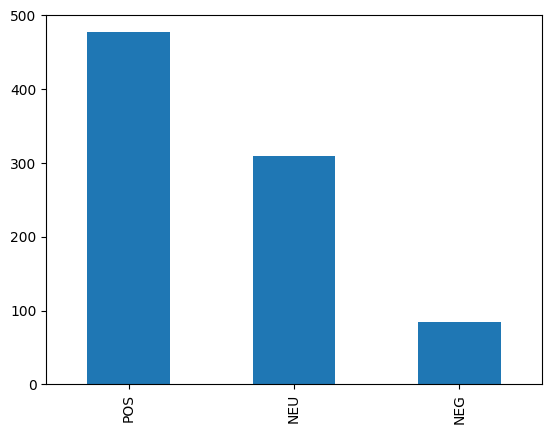

In [ ]:
comments_df['manual_label'].value_counts().plot.bar()

## Creación de los objetos "Dataset" de Huggingface

Como parte del proceso de sintonía fina, __Huggingface__ sugiere la creación de objetos llamados "Dataset", que facilitan la ejecución de dicho proceso.

Basicamente un objeto "Dataset" de Hugging Face es una estructura de datos optimizada para el procesamiento de lenguaje natural. Proporciona eficiencia en el manejo de grandes conjuntos de datos, compatibilidad con transformaciones y pipelining, integración con modelos y herramientas de entrenamiento, y compatibilidad con estándares de la industria.


In [ ]:
def create_hf_dataset(df, text_column, label_column):
  """
  Crea dos objetos Dataset de HF a partir de un df con los datos.
  """
  df = df.dropna(subset=[label_column])

  class_names = ['POS', 'NEG', 'NEU']
  sentiment_features = Features({text_column:Value('string'), label_column:ClassLabel(names=class_names)})

  train_df, test_df = train_test_split(df, test_size=0.2, stratify=df[label_column])

  train_ds = Dataset.from_pandas(train_df, split='train', features=sentiment_features, preserve_index=False)
  test_ds = Dataset.from_pandas(test_df, split='test', features=sentiment_features, preserve_index=False)

  return train_ds, test_ds

In [ ]:
fine_tune_df = comments_df.loc[:,['comment_text', 'manual_label']]
fine_tune_df.rename(columns={'comment_text':'text', 'manual_label':'label'}, inplace=True)

In [ ]:
fine_tune_df.shape

(69013, 2)

In [ ]:
fine_tune_df.head()

Ahora creamos instancias de los datasets de entrenamiento, y de pruebas basados en el dataset original.

In [ ]:
train_ds, test_ds = create_hf_dataset(fine_tune_df, 'text', 'label')

In [ ]:
comments_df['comment_text'] = comments_df['comment_text'].apply(clean_text)

Ahora ejecutamos el proceso de sintonía fina en sí:

In [ ]:
fine_tuned_comments_df = fine_tune_model(comments_df, train_ds, test_ds, 'text', 'label')

Some weights of the model checkpoint at pysentimiento/robertuito-base-uncased were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at pysentimiento/robertuito-base-uncased and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.dense.

Map:   0%|          | 0/696 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Map:   0%|          | 0/175 [00:00<?, ? examples/s]

{'text': 'cono respondieron mi peticion jajaja gloria a dios', 'label': 2, 'input_ids': [0, 1157, 1479, 3363, 507, 656, 962, 526, 4046, 7381, 412, 1087, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

<ipython-input-19-b80069b1d6cc>:44: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.480692,0.817143
2,No log,0.606695,0.805714
3,No log,0.829718,0.828571
4,No log,0.918659,0.817143
5,No log,0.990357,0.800000
6,0.184400,0.995809,0.805714
7,0.184400,1.023380,0.805714
8,0.184400,1.035467,0.800000
9,0.184400,1.038383,0.800000
10,0.184400,1.042775,0.800000


Accuracy: 0.80


El "accuracy" del modelo es de 80 %, y como comentamos anteriormente esto significa un aumento de 10 puntos porcentuales frente al modelo "vainilla", lo que para efectos de nuestro proyecto es muy bueno.

Veamos algunos comentarios negativos:

In [ ]:
fine_tuned_comments_df[fine_tuned_comments_df['fine-tuned_label']=='NEG']

,video_id,video_title,video_date,comment_text,comment_date,sentimiento,manual_label,Diferent,fine-tuned_label
89,bXKXFs5z9as,[Free Cover Venezuela] Amor Fiel - Cochi,2017-10-14 19:21:19,el que hizo las tomas lo que hace es marear al...,2017-10-14 19:21:19,NEG,NEG,SI,NEG
179,r2y0PrMDXMM,"[Free Cover Venezuela] Juan Miguel - Como tu, ...",2017-12-11 23:48:20,comparado a todos los demas artistas que han e...,2017-12-11 23:48:20,NEG,NEG,SI,NEG
195,r2y0PrMDXMM,"[Free Cover Venezuela] Juan Miguel - Como tu, ...",2017-12-11 23:48:20,esa sayonara si es feano me gusta,2017-12-11 23:48:20,NaN,NEG,NO,NEG
234,r2y0PrMDXMM,"[Free Cover Venezuela] Juan Miguel - Como tu, ...",2017-12-11 23:48:20,no em gustaba juan miguel hasta escucharlo aqu...,2017-12-11 23:48:20,POS,NaN,NO,NEG
405,IZJ49j1LIhk,[Free Cover Venezuela] Carlos Parra - Maquina ...,2017-11-12 19:12:35,no chico que mala suerte nada exitoso es lo ...,2017-11-12 19:12:35,POS,NaN,NO,NEG
...,...,...,...,...,...,...,...,...,...
70283,J1DUAY8BgaQ,Karaoke [Free Cover Venezuela] Ronald Borjas ...,2020-09-17 22:59:18,buenazaaa a mi q no me gusta el karaokee diosm...,2020-09-17 22:59:18,NaN,NaN,SI,NEG
70318,oRgnzievS94,In side Free Cover Raquel & Portillo,2023-02-14 15:03:40,sorry pero osman aray es un mega plomo,2023-02-14 15:03:40,NEG,NEG,SI,NEG
70327,oRgnzievS94,In side Free Cover Raquel & Portillo,2023-02-14 15:03:40,quien es esa raquelme parec una roba show y ...,2023-02-14 15:03:40,POS,NEG,NO,NEG
70357,mxxeNLCcVQ4,[IN-SIDE] Free Cover - Sandy y Papo (@MagicJua...,2022-10-27 02:27:27,todo bien menos esa introduccion con osman ara...,2022-10-27 02:27:27,NEG,NEG,SI,NEG


Se pueden observar algunos comentarios clasificados como negativos, que anteriormente habían sido clasificados como positivos, y que en efecto son negativos, y también podemos observar comentarios clasificados como negativos que no lo son, y de allí que hay todavía un 20 % de los comentarios que podrían ser clasificados erróneamente. Este último caso, es prácticamente imposible de reducir a 0 %, y definitivamente no es el espíritu de nuestro proyecto, por lo que nos vamos a quedar con este modelo.

Ahora filtramos las columnas, y las ordenamos como queremos que queden en el producto final:

In [ ]:
fine_tuned_comments_df = fine_tuned_comments_df.loc[:,[
    'video_id',
    'video_title',
    'video_date',
    'comment_text',
    'comment_date',
    'sentimiento',
    'manual_label',
    'fine-tuned_label']]

In [ ]:
fine_tuned_comments_df

,video_id,video_title,video_date,comment_text,comment_date,sentimiento,manual_label,fine-tuned_label
0,bI-w7HaeJPU,[Free Cover Venezuela] Amor Sincero / La estoy...,2017-10-22 20:49:49,inviten a guzman musica,2017-10-22 20:49:49,NEU,NEU,NEU
1,bI-w7HaeJPU,[Free Cover Venezuela] Amor Sincero / La estoy...,2017-10-22 20:49:49,debo reconocer que este free cover y el de jua...,2017-10-22 20:49:49,POS,NaN,POS
2,bI-w7HaeJPU,[Free Cover Venezuela] Amor Sincero / La estoy...,2017-10-22 20:49:49,jabon sincero,2017-10-22 20:49:49,NaN,NEU,NEU
3,bI-w7HaeJPU,[Free Cover Venezuela] Amor Sincero / La estoy...,2017-10-22 20:49:49,enamorada de los freecover,2017-10-22 20:49:49,POS,NaN,NEU
4,bI-w7HaeJPU,[Free Cover Venezuela] Amor Sincero / La estoy...,2017-10-22 20:49:49,un free cover de guacode adolescentes los prim...,2017-10-22 20:49:49,POS,NaN,POS
...,...,...,...,...,...,...,...,...
70448,mxxeNLCcVQ4,[IN-SIDE] Free Cover - Sandy y Papo (@MagicJua...,2022-10-27 02:27:27,va a estar bueno,2022-10-27 02:27:27,POS,POS,POS
70449,mxxeNLCcVQ4,[IN-SIDE] Free Cover - Sandy y Papo (@MagicJua...,2022-10-27 02:27:27,activo esperando,2022-10-27 02:27:27,NEU,NEU,NEU
70450,mxxeNLCcVQ4,[IN-SIDE] Free Cover - Sandy y Papo (@MagicJua...,2022-10-27 02:27:27,hola,2022-10-27 02:27:27,NEU,NEU,NEU
70451,mxxeNLCcVQ4,[IN-SIDE] Free Cover - Sandy y Papo (@MagicJua...,2022-10-27 02:27:27,aqui estamos desde mcbo,2022-10-27 02:27:27,NEU,NEU,NEU


Como paso final, guardamos el resultado en nuestro drive, de manera de poder recuperarlo y poder utilizarlo a nuestro antojo, en nuestro caso, lo rescataremos y lo colocaremos en el repositorio, de manera de que quien lo desee utilizar lo pueda hacer, sin tener que ejecutar este Colab.

In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')

# Ask the user to enter the filename
filename = "Comentarios_clasificados_fine-tuned-FreeCover(v2).csv"

# Join the user-entered filename with the drive directory path
path = os.path.join('/content/drive/My Drive', filename)

# Write to the specified file
with open(path, 'w', encoding='latin1') as f:
    fine_tuned_comments_df.to_csv(f, sep=';')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
